<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Departamento de Datos no Estructurados  </h1>


<p style=»text-align: justify;»>
El Departamento de Analítica No estructurada busca profesionales con fuertes capacidades técnicas y sobretodo una fuerte capacidad analítica. Por consiguiente esta prueba intenta poner a prueba la forma en la que plantea y soluciona problmeas. Es importante que presente el código que usa para resolver el problema con el único motivo de medir sus capacidades.

Se recomienda que sea ordenado en su código y siga los lineamientos establecidos, aún así la prueba tiene un grado de flexibilidad. Se evaluará el orden y la creatividad a la hora de presentar la información. 
</p>


**Nota** <br>
Tenga en cuenta que éste ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habiliadades para el cargo


#### **Objetivo**
El objetivo de esta prueba es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas en blanco y otra con imágenes de páginas con contenido.

Páginas con solo el membrete del documento se consideran páginas en blanco, así como las que, al momento de ser escaneadas, alcanzan a reflejar contenido ininteligible del reverso de la página.

## Clasificación de Imágenes

### 0.Librerías

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-23.0.1-py3-none-any.whl.metadata (4.1 kB)
  Using cached Pillow-9.4.0-cp39-cp39-win_amd64.whl.metadata (9.5 kB)
  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
Using cached Pillow-9.4.0-cp39-cp39-win_amd64.whl (2.5 MB)


ERROR: To modify pip, please run the following command:
C:\ProgramData\Anaconda3\python.exe -m pip install -r requirements.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

from numpy import mean
from numpy import std
from scipy.stats import truncnorm

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import glob

import matplotlib.image as mpimg

### 1.Importe las imágenes
En la carpeta adjunta se encontrará con documentos tanto en blanco como con contenido. Su objetivo es generar un modelo que clasifique los elementos en "Con Contenido" y "Sin Contenido". Para eso puede utilizar reglas o modelos especificos.

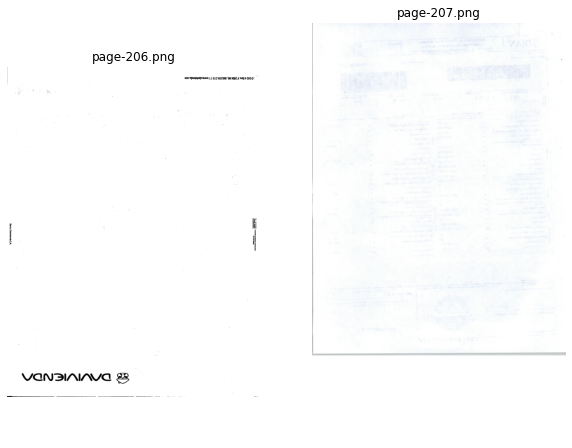

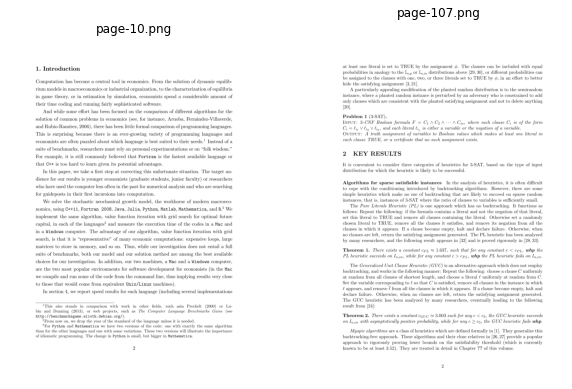

In [3]:
def mostrar_imagenes(carpeta, num_imagenes=2):
    imagenes = [f for f in os.listdir(carpeta) if f.endswith(('.png'))]
    imagenes = imagenes[:num_imagenes]
    
    fig, axes = plt.subplots(1, num_imagenes, figsize=(10, 10))
    for ax, img in zip(axes, imagenes):
        img_path = os.path.join(carpeta, img)
        img_data = mpimg.imread(img_path)
        ax.imshow(img_data, cmap='gray')
        ax.axis('off')
        ax.set_title(img)
    plt.show()

# Mostrar imágenes de la carpeta Blanco
mostrar_imagenes('Imagenes/Blanco')

# Mostrar imágenes de la carpeta Documentos
mostrar_imagenes('Imagenes/Documentos')

Dimensiones de la imagen antes de preprocesar: (1224, 1584)


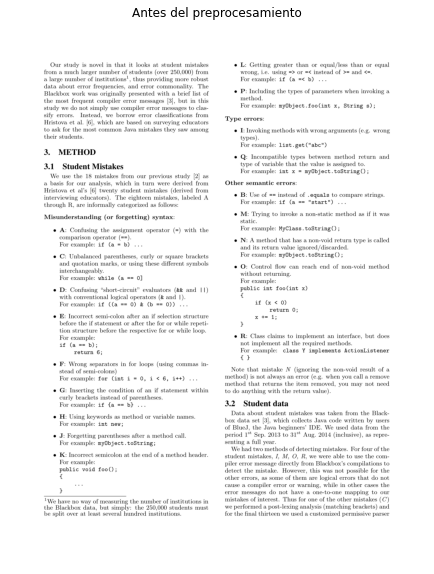

Dimensiones de la imagen después de preprocesar: (448, 448)


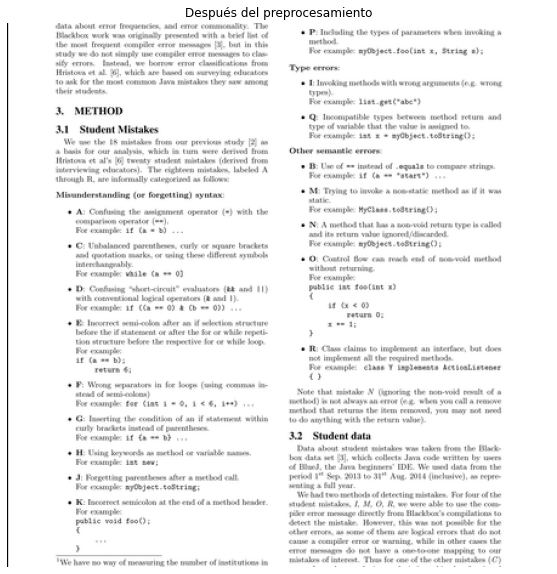

Etiqueta de la imagen: 1


In [4]:
# Definir la lista de rutas de imágenes
imgList = [
    'Imagenes/Documentos/page-2.png'
]

# Función para redimensionar la imagen manteniendo la relación de aspecto
def resizeAspect(im, size):
    w, h = im.size
    aspect = max(size[0] / float(w), size[1] / float(h))
    return im.resize((int(w * aspect), int(h * aspect)), Image.LANCZOS)

# Función para centrar la imagen en un lienzo de tamaño fijo
def centerImage(im, size):
    w, h = im.size
    new_im = Image.new("RGB", size, (255, 255, 255))  # Crear un lienzo blanco
    new_im.paste(im, ((size[0] - w) // 2, (size[1] - h) // 2))
    return new_im

# Procesar solo una imagen de ejemplo
img_path = imgList[0]
img = Image.open(img_path)

# Imprimir las dimensiones de la imagen antes de preprocesar
print(f"Dimensiones de la imagen antes de preprocesar: {img.size}")

# Mostrar la imagen antes del preprocesamiento
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.title('Antes del preprocesamiento')
plt.axis('off')
plt.show()

# Preprocesar la imagen
w, h = img.size
if min(w, h) < 1500:
    img = resizeAspect(img, (448, 448))
    w, h = img.size
center = [int(w / 2), int(h / 2)]
box = (center[0] - 224, center[1] - 224, center[0] + 224, center[1] + 224)
cropped_img = img.crop(box)

# Imprimir las dimensiones de la imagen después de preprocesar
print(f"Dimensiones de la imagen después de preprocesar: {cropped_img.size}")

# Mostrar la imagen después del preprocesamiento
plt.figure(figsize=(10, 10))
plt.imshow(cropped_img, cmap='gray')
plt.title('Después del preprocesamiento')
plt.axis('off')
plt.show()

# Convertir la imagen a un array y aplanarla
img_array = np.array(cropped_img).flatten()

# Determinar la etiqueta basada en el nombre del archivo
etiqueta = 0 if 'Blanco' in img_path else 1

# Imprimir la etiqueta de la imagen
print(f"Etiqueta de la imagen: {etiqueta}")

Como en este ejercicio no nos interesa analizar el contenido de los documentos, realizamos un proceso de re escalamiento de las imagenes para que sean más ligeras y fáciles de interpretar para el modelo.

### 2. Estructure la información
Debido a que las imagenes son archivos separados lo primero que debe hacer es importarlas (recuerde que una imagen es esencialmente un arreglo de vectores), puede esturcturarlas a su gusto y marcar de ser necesario aquellas que va usar como test de pruebas. 

In [10]:
import os
import shutil
import random
from PIL import Image
import numpy as np

# Función para redimensionar la imagen manteniendo la relación de aspecto
def resizeAspect(im, size):
    w, h = im.size
    aspect = max(size[0] / float(w), size[1] / float(h))
    return im.resize((int(w * aspect), int(h * aspect)), Image.LANCZOS)

# Función para centrar la imagen en un lienzo de tamaño fijo
def centerImage(im, size):
    w, h = im.size
    new_im = Image.new("RGB", size, (255, 255, 255))  # Crear un lienzo blanco
    new_im.paste(im, ((size[0] - w) // 2, (size[1] - h) // 2))
    return new_im

run_preprocess = False

if run_preprocess == False:

    # Definir las carpetas de origen
    carpetas_origen = ['Imagenes/cropped/Blanco', 'Imagenes/cropped/Documentos']
    carpeta_destino = 'Imagenes/validar_final'
    
    # Crear las carpetas de destino si no existen
    os.makedirs(os.path.join(carpeta_destino, 'Blanco'), exist_ok=True)
    os.makedirs(os.path.join(carpeta_destino, 'Documentos'), exist_ok=True)
    
    # Seleccionar 10 imágenes al azar de cada carpeta para la validación final
    for carpeta in carpetas_origen:
        imagenes = [img for img in os.listdir(carpeta) if img.endswith('.png')]
        imagenes_validar = random.sample(imagenes, 10)
        
        for img_name in imagenes_validar:
            img_path = os.path.join(carpeta, img_name)
            if 'Blanco' in carpeta:
                destino_path = os.path.join(carpeta_destino, 'Blanco', img_name)
            elif 'Documentos' in carpeta:
                destino_path = os.path.join(carpeta_destino, 'Documentos', img_name)
            shutil.copy(img_path, destino_path)
#             print(f"Copiada: {img_path} a {destino_path}")
            
            
if run_preprocess:
    
    # Definir las carpetas de origen
    carpetas_origen = [
        'Imagenes/Documentos',
        'Imagenes/Blanco'
    ]
    carpeta_destino = 'Imagenes/cropped'
    carpeta_validar_final = 'Imagenes/validar_final'
    
    # Crear las subcarpetas de destino si no existen
    os.makedirs(os.path.join(carpeta_destino, 'Blanco'), exist_ok=True)
    os.makedirs(os.path.join(carpeta_destino, 'Documentos'), exist_ok=True)
    os.makedirs(os.path.join(carpeta_validar_final, 'Blanco'), exist_ok=True)
    os.makedirs(os.path.join(carpeta_validar_final, 'Documentos'), exist_ok=True)

    contador_blanco = 0
    contador_documentos = 0

    # Seleccionar 10 imágenes al azar de cada carpeta para la validación final
    imagenes_validar = {}
    for carpeta in carpetas_origen:
        imagenes = [img for img in os.listdir(carpeta) if img.endswith('.png')]
        imagenes_validar[carpeta] = random.sample(imagenes, 10)

    # Procesar todas las imágenes en las carpetas de origen
    for carpeta in carpetas_origen:
        for img_name in os.listdir(carpeta):
            if img_name.endswith('.png'):
                img_path = os.path.join(carpeta, img_name)
                img = Image.open(img_path)

                # Determinar la etiqueta basada en el nombre del archivo
                etiqueta = 'Blanco' if 'Blanco' in carpeta else 'Documentos'

                # Si la imagen está en la lista de validación, moverla a la carpeta de validación final
                if img_name in imagenes_validar[carpeta]:
                    validar_img_path = os.path.join(carpeta_validar_final, etiqueta, img_name)
                    img.save(validar_img_path, 'PNG')
                    print(f"Imagen {img_name} movida a la carpeta de validación final.")
                    continue

                print(f"Dimensiones de la imagen antes de preprocesar: {img.size}")
                img = resizeAspect(img, (448, 448))
                img = centerImage(img, (448, 448))
                print(f"Dimensiones de la imagen después de preprocesar: {img.size}")

                # Guardar la imagen procesada en la subcarpeta de destino correspondiente
                cropped_img_name = f"{os.path.splitext(img_name)[0]}_{etiqueta}.png"
                cropped_img_path = os.path.join(carpeta_destino, etiqueta, cropped_img_name)
                img.save(cropped_img_path, 'PNG')

                if etiqueta == 'Blanco':
                    contador_blanco += 1
                else:
                    contador_documentos += 1

                print(f"Etiqueta de la imagen: {etiqueta}")

    print(f"Cantidad de imágenes en la carpeta 'Blanco': {contador_blanco}")
    print(f"Cantidad de imágenes en la carpeta 'Documentos': {contador_documentos}")

else:
    print("Las imágenes ya se encuentran preprocesadas")

Las imágenes ya se encuentran preprocesadas


### 3. Describa su Estrategia de Análisis
<p>Tiene libertad en la metodología para la clasificación. Aún así debe describir brevemente como realizará el análisis. Por ejemplo, si usará un modelo en donde requiera clasificar una cantidad pequeña de la data mencionelo o si planea condicionar la clasifiaciónes a reglas indique que reglas usará. Además si usa herramientas externas describalas y explique. </p>


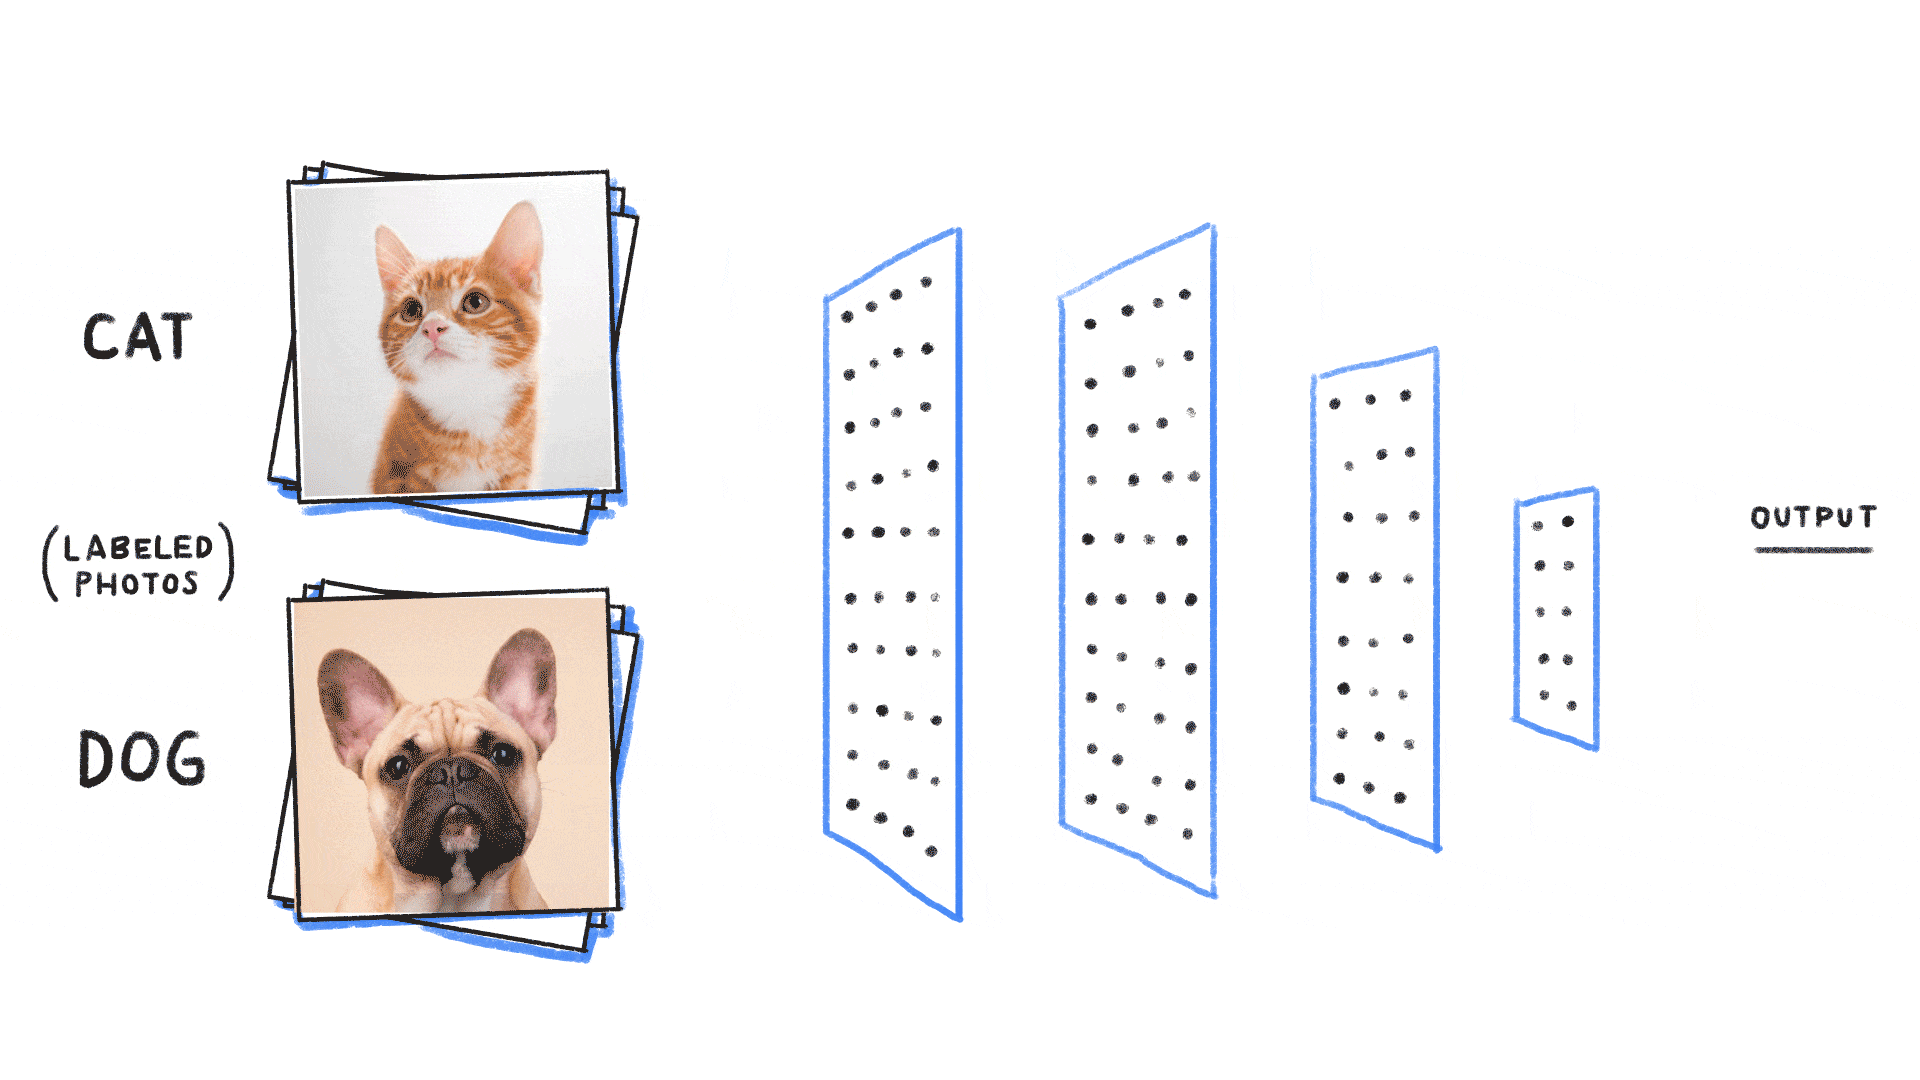

Se emplea un modelo convolucional que clasifica las imágenes basándose su contenido visual.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

# Crear un generador de datos con aumento de datos
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cargar las imágenes de entrenamiento y validación
train_generator = datagen.flow_from_directory(
    'Imagenes/cropped',
    target_size=(224, 224),  # Reducir el tamaño de la imagen para acelerar el entrenamiento
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    'Imagenes/cropped',
    target_size=(224, 224),  # Reducir el tamaño de la imagen para acelerar el entrenamiento
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Contar las imágenes de cada clase
blanco_count = sum(['Blanco' in f for f in train_generator.filenames])
documentos_count = sum(['Documentos' in f for f in train_generator.filenames])

print(f"Found {blanco_count} images belonging to 'Blanco' class.")
print(f"Found {documentos_count} images belonging to 'Documentos' class.")

# Definir el modelo con regularización y más capas de Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=25,  # Aumentar el número de épocas
    validation_data=validation_generator
)

# Guardar el modelo entrenado
model.save('modelo_clasificacion_paginas_mejorado.h5')


Found 181 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 109 images belonging to 'Blanco' class.
Found 72 images belonging to 'Documentos' class.


C:\Users\gabrieva\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\gabrieva\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5582 - loss: 0.7465 - val_accuracy: 0.6136 - val_loss: 0.6439
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6350 - loss: 0.6401 - val_accuracy: 0.7273 - val_loss: 0.6030
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7967 - loss: 0.5522 - val_accuracy: 0.9091 - val_loss: 0.5700
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6984 - loss: 0.5874 - val_accuracy: 0.6364 - val_loss: 0.5789
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8011 - loss: 0.4620 - val_accuracy: 0.9545 - val_loss: 0.4801
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9160 - loss: 0.3983 - val_accuracy: 0.7500 - val_loss: 0.4357
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9184 - loss: 0.3073 - val_accuracy: 0.8182 - val_loss: 0.3323
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9534 - loss: 0.2310 - val_accuracy: 0.9318 - val_loss: 0.3018
Epoch 9/25
6/6 ━

### 4. Interpretación de Resultados
<p>Al final tiene que presentar la información en una matriz que muestre la calidad de su clasificación y evaluarla con la medida que guste. </p>
<br>
<img src="https://www.ecured.cu/images/3/31/Matrices_de_confusi%C3%B3n.png" >

Se estableció una muestra de 20 imanges para backtesting llamada `validar_final` con el fin de ver el desempeño del modelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Imagen: page-172_Blanco.png, Predicción: 0.013669339939951897, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Imagen: page-174_Blanco.png, Predicción: 0.08823146671056747, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Imagen: page-181_Blanco.png, Predicción: 0.014148394577205181, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Imagen: page-185_Blanco.png, Predicción: 0.011086470447480679, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Imagen: page-189_Blanco.png, Predicción: 0.0170858446508646, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Imagen: page-207_Blanco.png, Predicción: 0.014008056372404099, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Imagen: page-228_Blanco.png, Predicción: 0.014802665449678898, Clase Predicha: 0, Clase Verdadera: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6

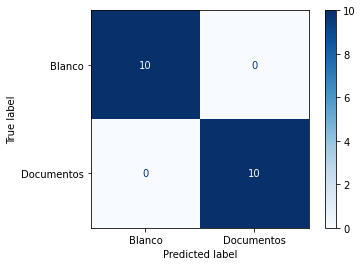

              precision    recall  f1-score   support

      Blanco       1.00      1.00      1.00        10
  Documentos       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [11]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
model = load_model('modelo_clasificacion_paginas_mejorado.h5')

# Crear carpetas de salida
output_dir_blanco = 'Imagenes/Blanco_evaluado'
output_dir_documentos = 'Imagenes/Documentos_evaluado'
os.makedirs(output_dir_blanco, exist_ok=True)
os.makedirs(output_dir_documentos, exist_ok=True)

def mover_imagenes(model, carpeta_entrada, umbral=0.5):
    y_true = []
    y_pred = []
    
    # Recorrer recursivamente las subcarpetas
    for root, dirs, files in os.walk(carpeta_entrada):
        for img_name in files:
            img_path = os.path.join(root, img_name)
            try:
                # Verificar que el archivo es una imagen
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    print(f"Archivo no soportado: {img_name}")
                    continue
                
                img = load_img(img_path, target_size=(224, 224))  # Asegurarse de que el tamaño de la imagen sea (224, 224)
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0) / 255.0

                prediccion = model.predict(img_array)
                prediccion_clase = 0 if prediccion < umbral else 1
                y_pred.append(prediccion_clase)

                # Etiqueta verdadera basada en la carpeta origen
                if 'Blanco' in root:
                    etiqueta_verdadera = 0
                elif 'Documentos' in root:
                    etiqueta_verdadera = 1
                else:
                    print(f"Carpeta desconocida: {root}")
                    continue
                y_true.append(etiqueta_verdadera)

                # Mover la imagen a la carpeta correspondiente
                if prediccion_clase == 0:
                    shutil.move(img_path, os.path.join(output_dir_blanco, img_name))
                else:
                    shutil.move(img_path, os.path.join(output_dir_documentos, img_name))

                # Imprimir información de depuración
                print(f"Imagen: {img_name}, Predicción: {prediccion[0][0]}, Clase Predicha: {prediccion_clase}, Clase Verdadera: {etiqueta_verdadera}")
            except PermissionError:
                print(f"Permiso denegado para el archivo: {img_path}")
            except Exception as e:
                print(f"Error procesando el archivo {img_path}: {e}")
    
    return y_true, y_pred

# Evaluar y mover las imágenes
y_true, y_pred = mover_imagenes(model, 'Imagenes/validar_final', umbral=0.5)

if y_true and y_pred:
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blanco', 'Documentos'])

    # Mostrar la matriz de confusión
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Calcular y mostrar las métricas de clasificación
    report = classification_report(y_true, y_pred, target_names=['Blanco', 'Documentos'])
    print(report)
else:
    print("No se encontraron imágenes válidas para evaluar.")

**SE EVIDENCIA UN BUEN RENDIMIENTO DEL MODELO, PREDICIENDO CORRECTAMENTE TODAS LAS IMAGENES DEL BACK TESTING**